# **PROJECT JARINGAN SYARAF TIRUAN - BACPROPAGATION**

## **Library**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from ucimlrepo import fetch_ucirepo
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
from imblearn.over_sampling import ADASYN, SMOTE
from scipy.stats import mstats
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import graphviz
import pydot

import warnings
warnings.filterwarnings('ignore')

seed = 42

In [192]:
# Activating GPU if available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU is activated")
    except:
        print("Could not set memory growth")

GPU is activated


## **Data**
Data source = [UC Irvine Machine Learning Repository: Default of Credit card](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

In [193]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
default_of_credit_card_clients = fetch_ucirepo(id=350) 

# data (as pandas dataframes) 
X = default_of_credit_card_clients.data.features 
y = default_of_credit_card_clients.data.targets 

# variable information 
print(default_of_credit_card_clients.variables) 

   name     role     type      demographic                 description units  \
0    ID       ID  Integer             None                        None  None   
1    X1  Feature  Integer             None                   LIMIT_BAL  None   
2    X2  Feature  Integer              Sex                         SEX  None   
3    X3  Feature  Integer  Education Level                   EDUCATION  None   
4    X4  Feature  Integer   Marital Status                    MARRIAGE  None   
5    X5  Feature  Integer              Age                         AGE  None   
6    X6  Feature  Integer             None                       PAY_0  None   
7    X7  Feature  Integer             None                       PAY_2  None   
8    X8  Feature  Integer             None                       PAY_3  None   
9    X9  Feature  Integer             None                       PAY_4  None   
10  X10  Feature  Integer             None                       PAY_5  None   
11  X11  Feature  Integer             No

This research employed a binary variable, default payment **(Yes = 1, No = 0)**, as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
- **X1**: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- **X2**: Gender (1 = male; 2 = female).
- **X3**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- **X4**: Marital status (1 = married; 2 = single; 3 = others).
- **X5**: Age (year).
- **X6 - X11**: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- **X12-X17**: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- **X18-X23**: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [194]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [195]:
y.head()

,Y
0,1
1,1
2,0
3,0
4,0


### **Removing Invalid Values**
After checking, several data were found that did not match the scale in the variable description. After inspection, several data points were found to be off-scale in the variable descriptions. This data was found in variables X3 and X4.

In [196]:
# Handle invalid values in X2 and X4 by setting them to NaN
X.loc[~X['X3'].isin([1, 2, 3, 4]), 'X3'] = np.nan
X.loc[~X['X4'].isin([1, 2, 3]), 'X4'] = np.nan

print("X3 value counts after cleaning:")
print(X['X3'].value_counts(dropna=False))
print("\nX4 value counts after cleaning:")
print(X['X4'].value_counts(dropna=False))

X3 value counts after cleaning:
2.0    14030
1.0    10585
3.0     4917
NaN      345
4.0      123
Name: X3, dtype: int64

X4 value counts after cleaning:
2.0    15964
1.0    13659
3.0      323
NaN       54
Name: X4, dtype: int64


In [197]:
data = pd.concat([X, y], axis=1)
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,20000,2,2.0,1.0,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2.0,2.0,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2.0,2.0,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2.0,1.0,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2.0,1.0,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3.0,1.0,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3.0,2.0,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2.0,2.0,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3.0,1.0,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


### **Statistic Descriptive**

In [198]:
data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
count,30000.000000,30000.000000,29655.000000,29946.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.817164,1.554665,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.711283,0.518259,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [199]:
data.isnull().sum()

X1       0
X2       0
X3     345
X4      54
X5       0
X6       0
X7       0
X8       0
X9       0
X10      0
X11      0
X12      0
X13      0
X14      0
X15      0
X16      0
X17      0
X18      0
X19      0
X20      0
X21      0
X22      0
X23      0
Y        0
dtype: int64

In [200]:
missing_percentage = data.isnull().mean() * 100
missing_percentage

X1     0.00
X2     0.00
X3     1.15
X4     0.18
X5     0.00
X6     0.00
X7     0.00
X8     0.00
X9     0.00
X10    0.00
X11    0.00
X12    0.00
X13    0.00
X14    0.00
X15    0.00
X16    0.00
X17    0.00
X18    0.00
X19    0.00
X20    0.00
X21    0.00
X22    0.00
X23    0.00
Y      0.00
dtype: float64

In [201]:
data.duplicated().sum()

35

In [202]:
duplicate_precentage = (data.duplicated().sum() / len(data)) * 100
print(f"Percentage of duplicate rows: {duplicate_precentage:.2f}%")

Percentage of duplicate rows: 0.12%


## **EDA**

In [203]:
num_features = data.drop(['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'Y'], axis=1).columns
cat_features = data[['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']].columns

print("Numerical Features:", num_features.tolist())
print("Categorical Features:", cat_features.tolist())

Numerical Features: ['X1', 'X5', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']
Categorical Features: ['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']


### **Feature Distribution**

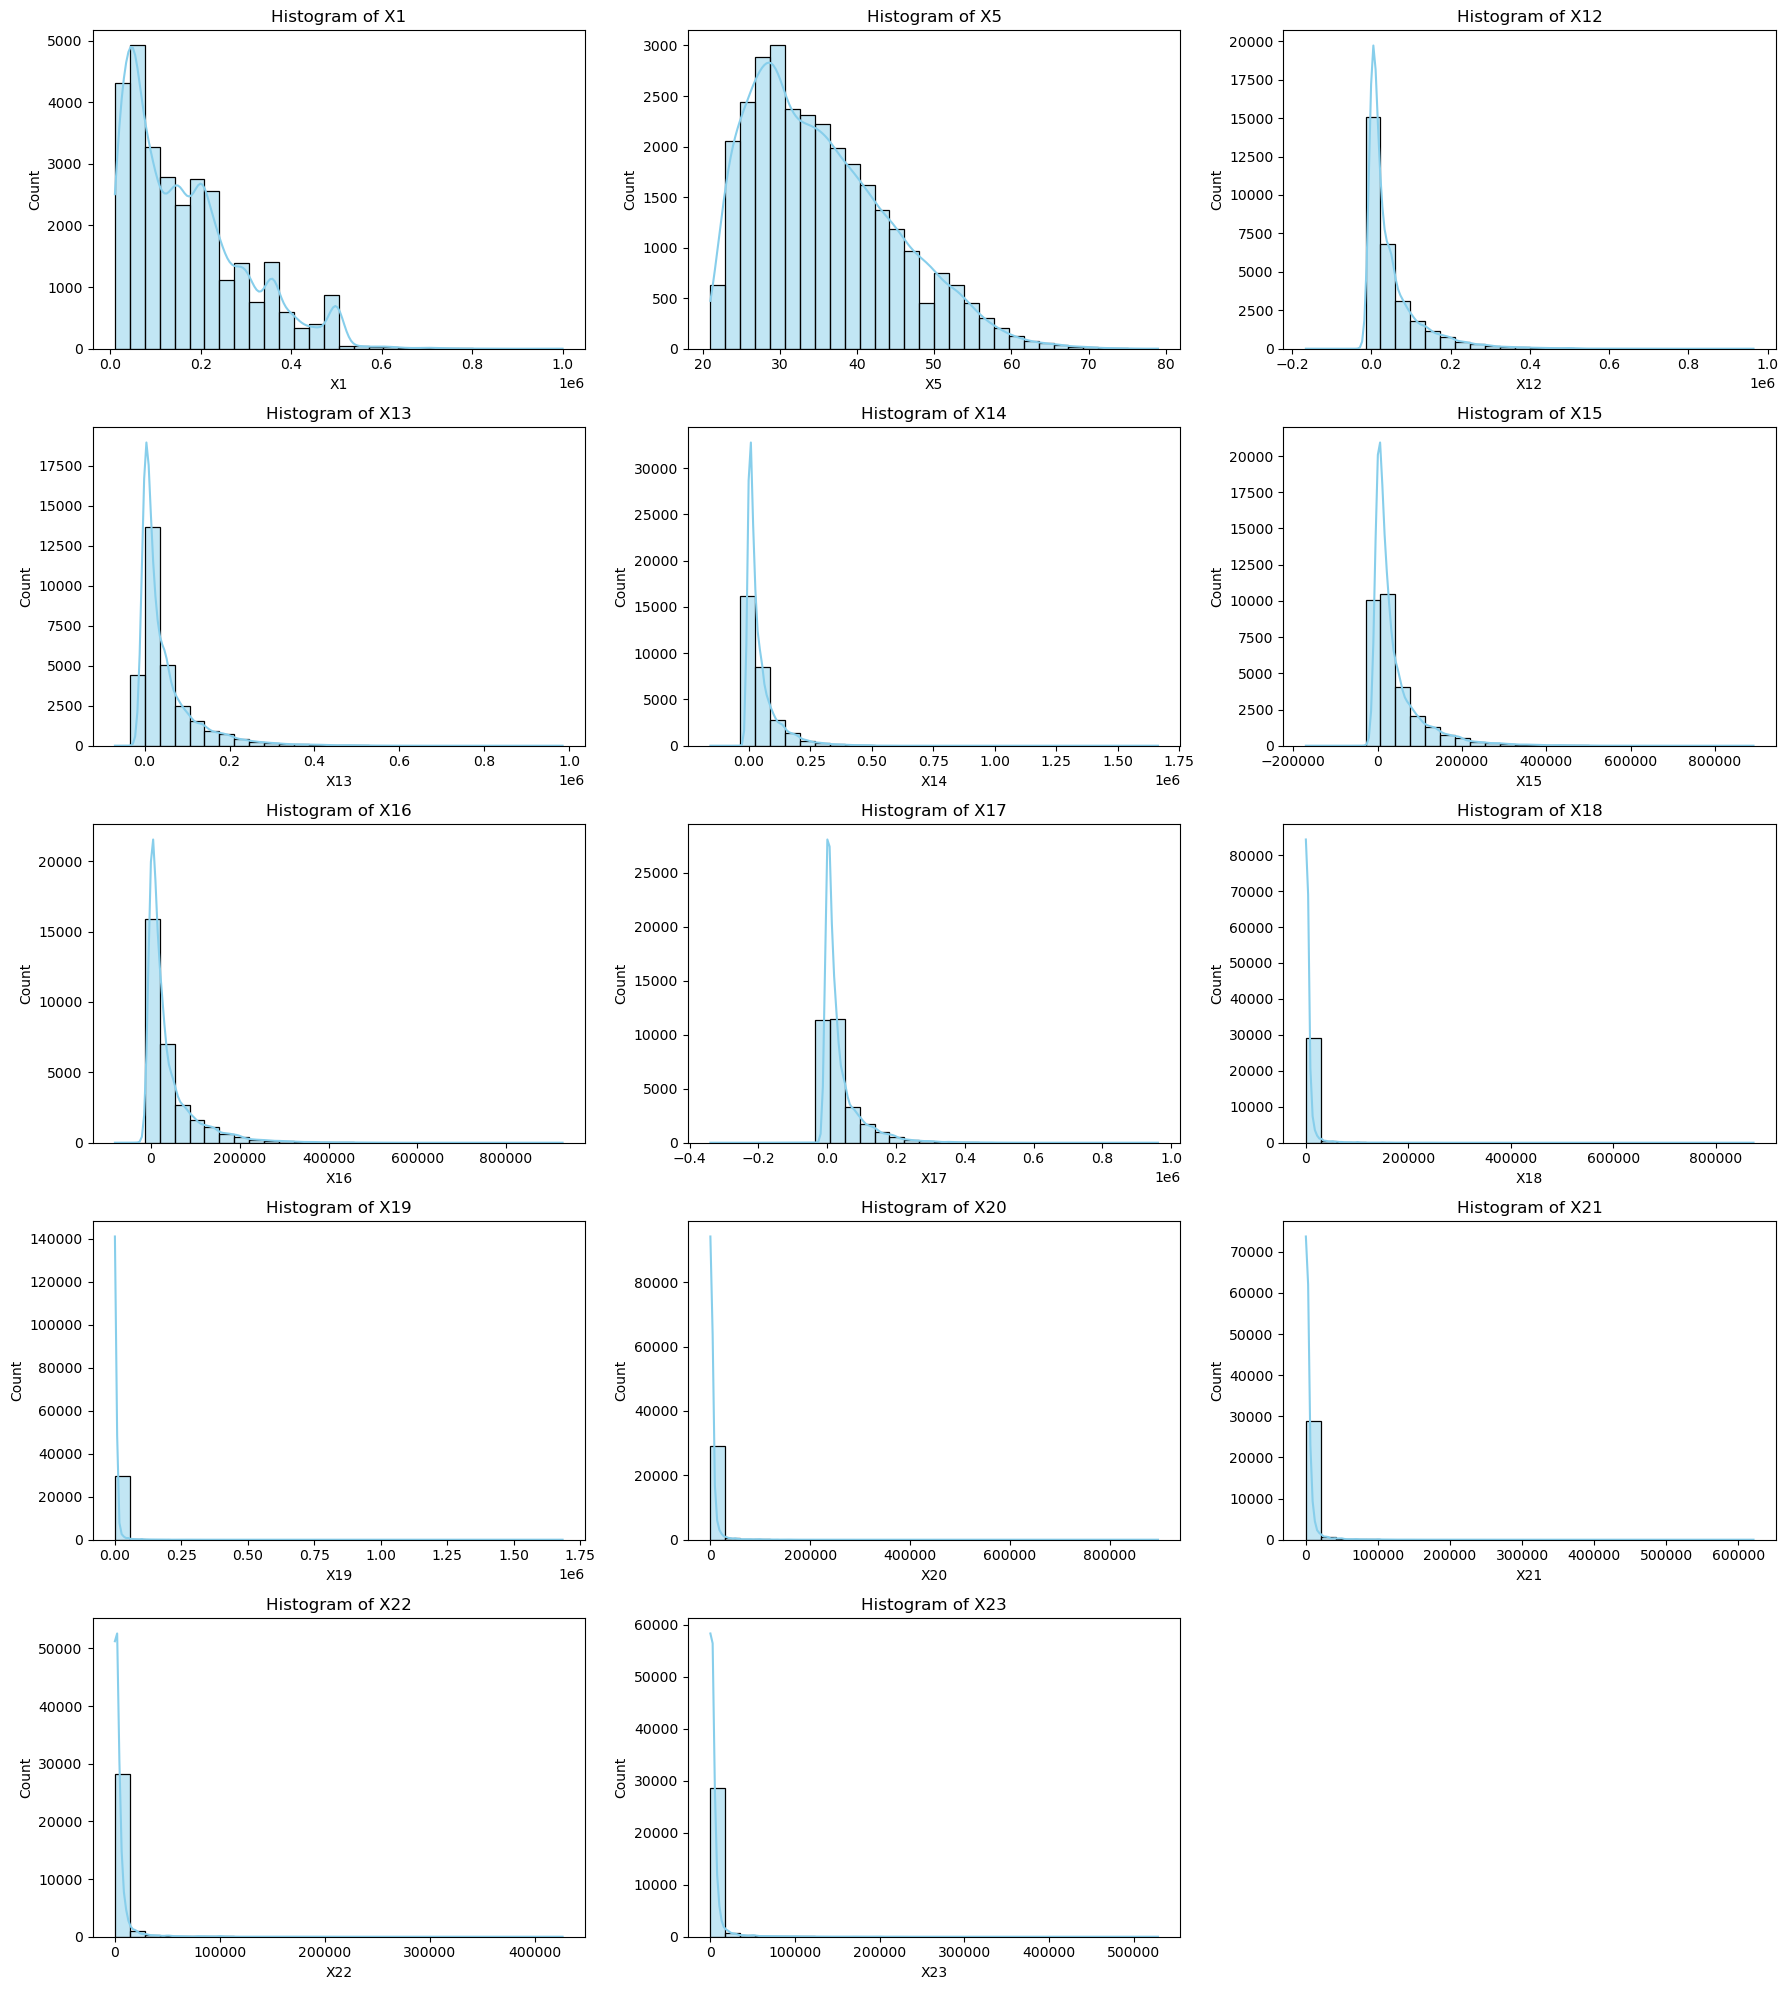

In [204]:
# visualize the distribution of the numerical features
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
axes = axes.flatten()
for i, column in enumerate(num_features):
    sns.histplot(data[column], bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram of {column}')

# Hide unused subplots
for j in range(len(num_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

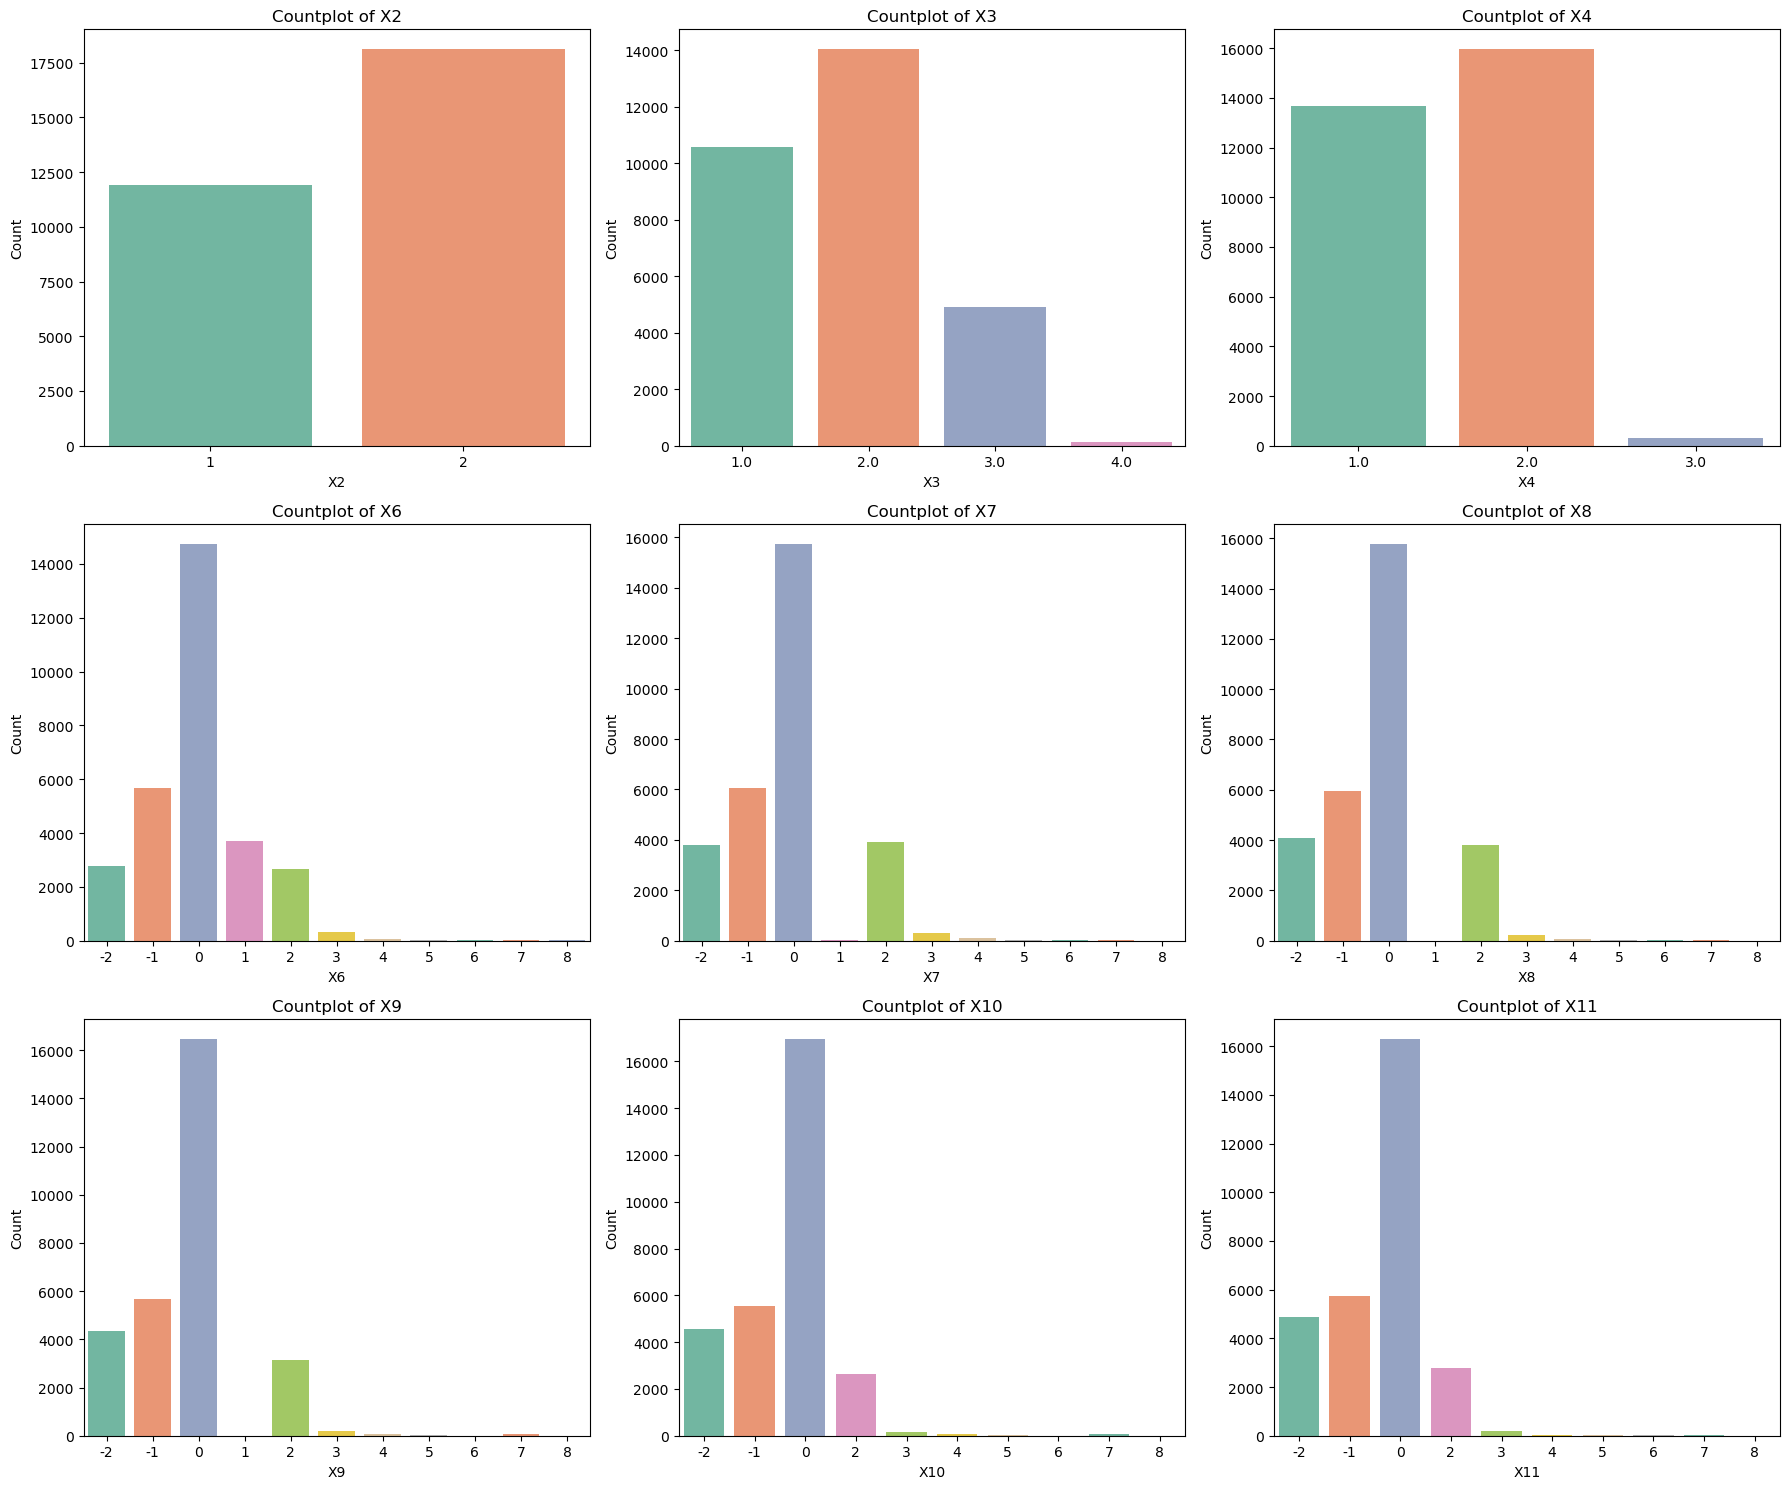

In [205]:
# visualization of categorical features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.flatten()
for i, column in enumerate(cat_features):
    sns.countplot(x=data[column], ax=axes[i], palette='Set2')
    axes[i].set_title(f'Countplot of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

### **Boxplot**

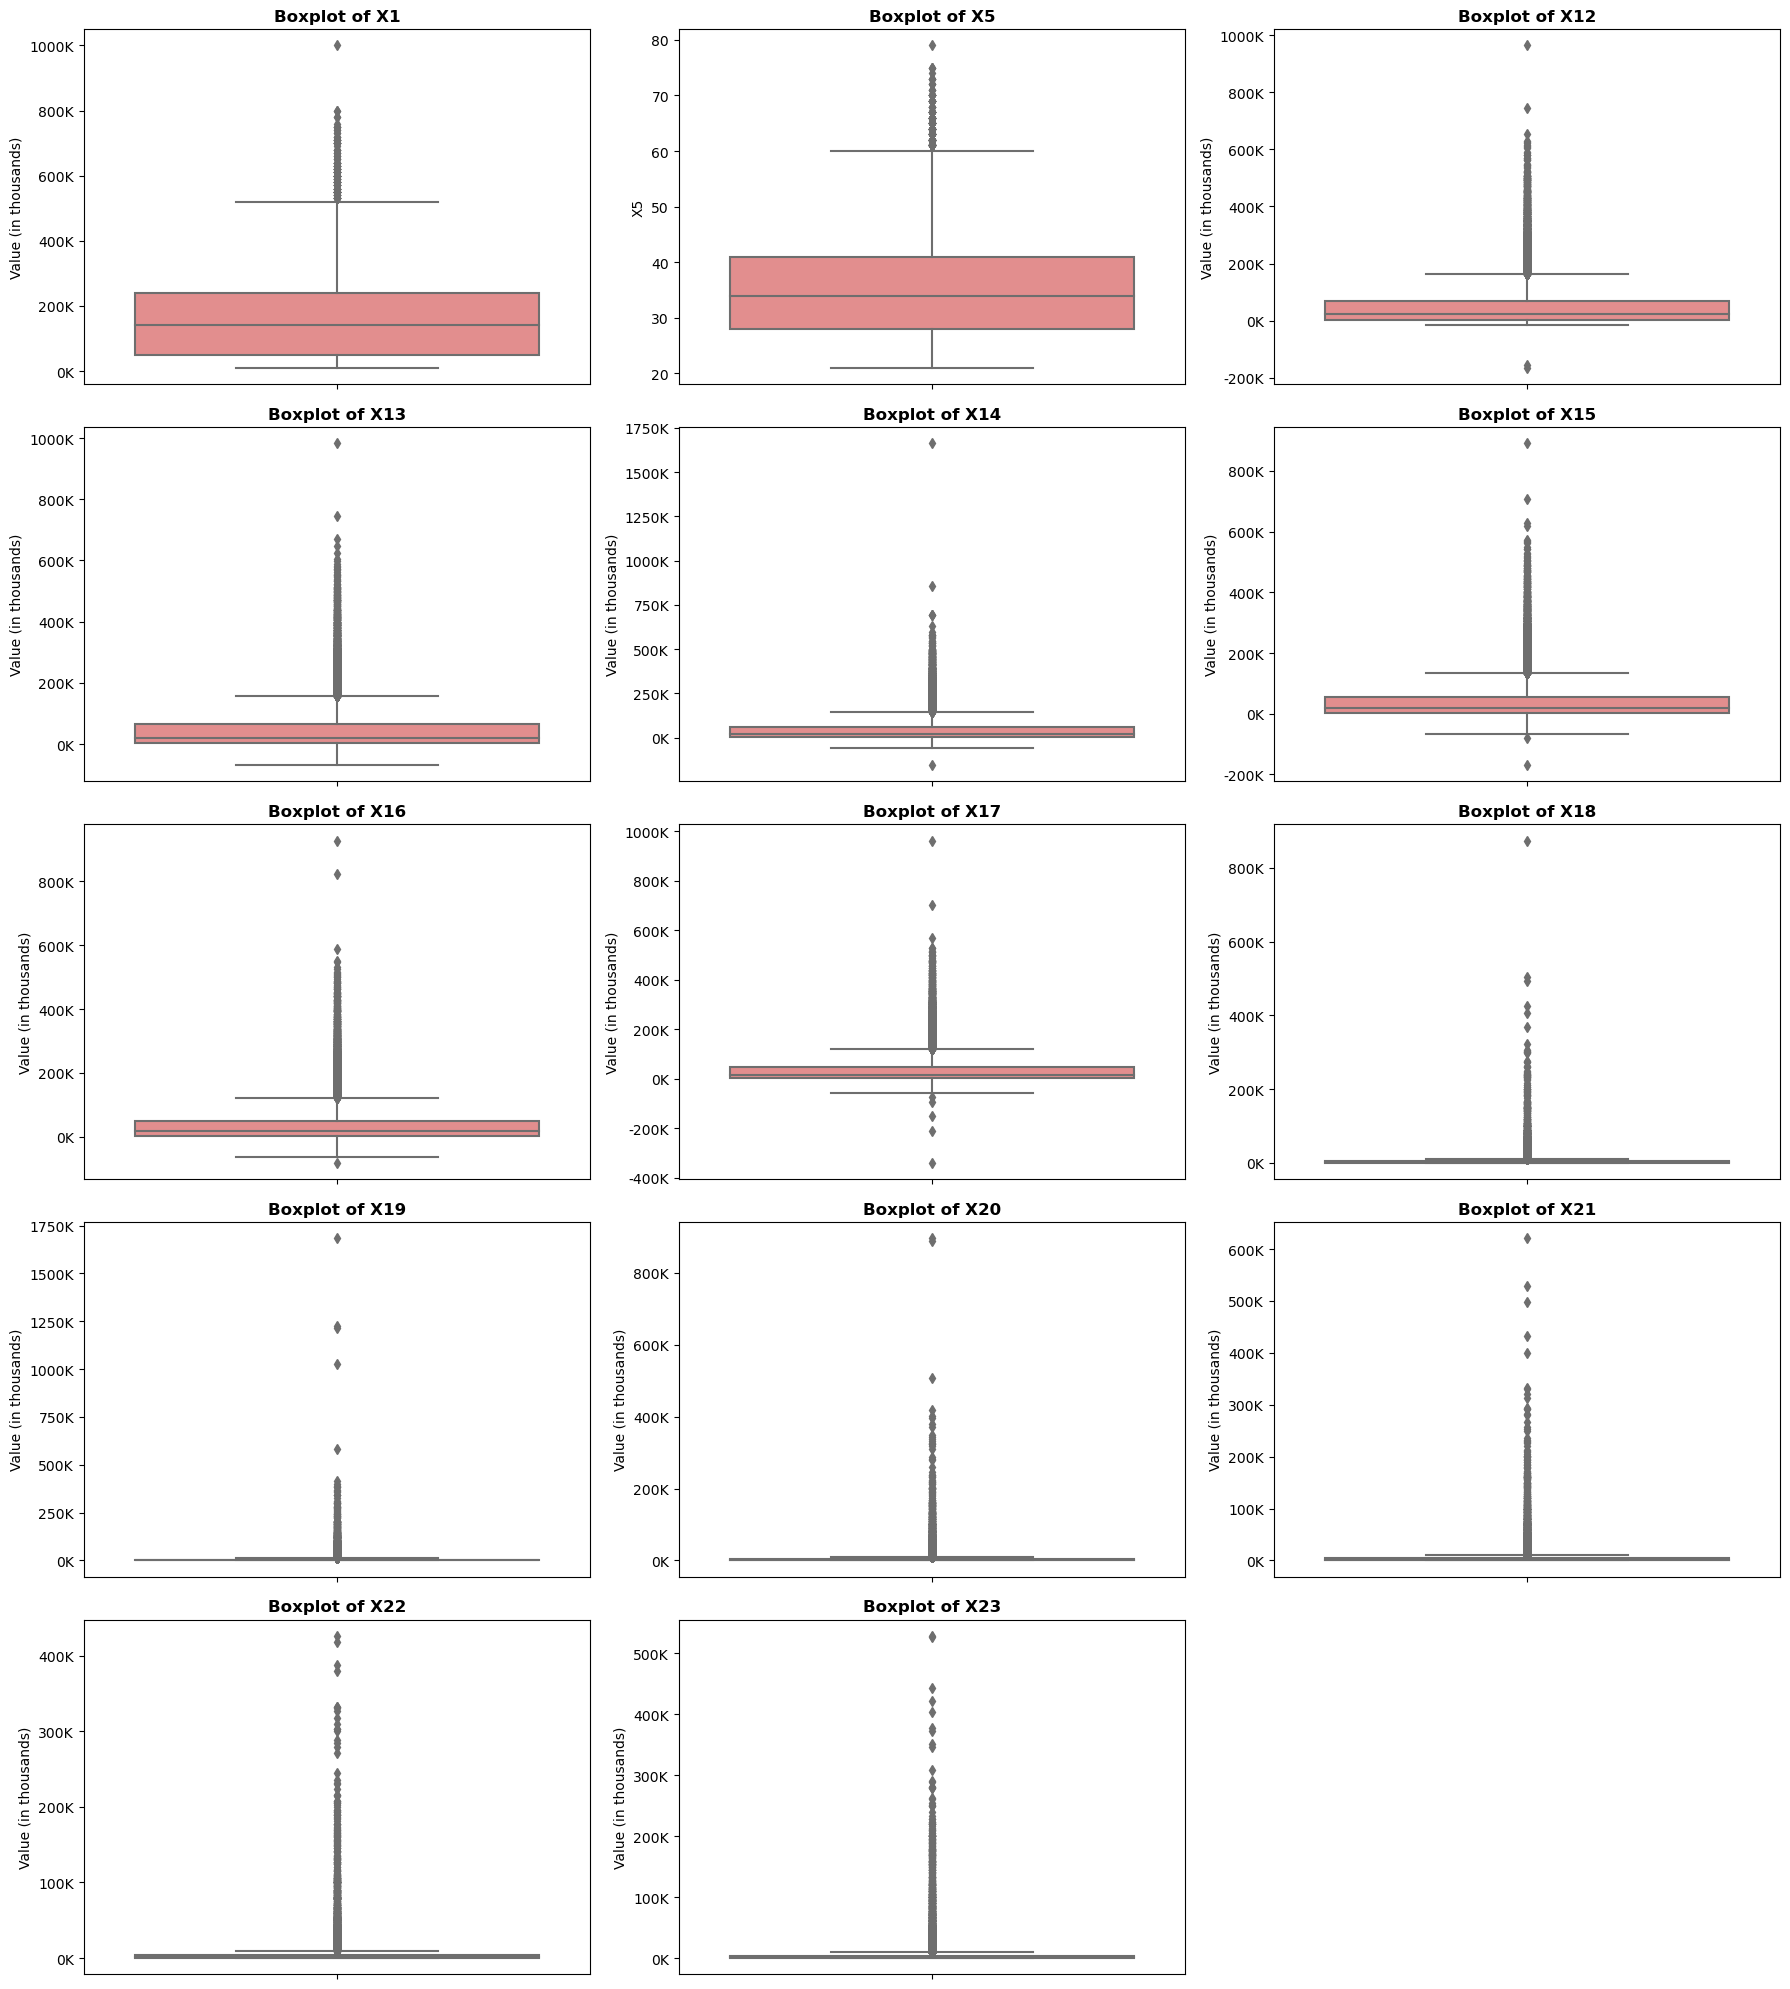

In [206]:
# Boxplot for checking outliers
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
axes = axes.flatten()
for i, column in enumerate(num_features):
    # Create boxplot
    sns.boxplot(y=data[column], ax=axes[i], color='lightcoral')
    axes[i].set_title(f'Boxplot of {column}', fontsize=12, fontweight='bold')
    
    # Format y-axis for better readability
    if data[column].max() > 10000:
        axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
        axes[i].set_ylabel('Value (in thousands)')

# Hide unused subplots
for j in range(len(num_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### **Target Distribution**

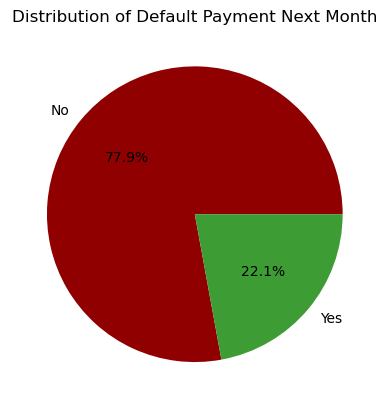

In [207]:
# visualize the distribution of the target variable
plt.pie(data['Y'].value_counts(), labels=['No', 'Yes'], autopct='%1.1f%%', colors=['#900000', '#3e9c35'])
plt.title('Distribution of Default Payment Next Month')
plt.show()

### **Correlation**

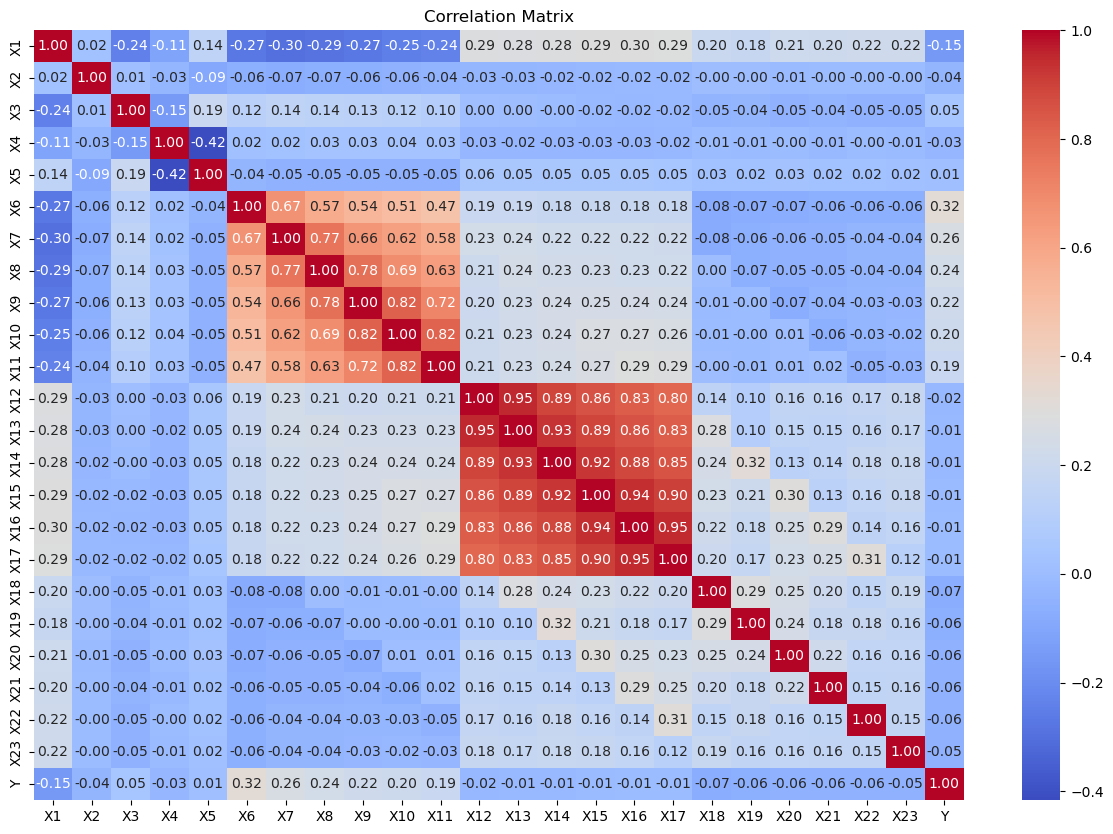

In [208]:
# Correlation matrix
plt.figure(figsize=(15,10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## **Preprocessing**

### **Handling Missing Values**

In [209]:
imputer = SimpleImputer(strategy='most_frequent')
data[['X3', 'X4']] = imputer.fit_transform(data[['X3', 'X4']])

In [210]:
data.isnull().sum() 

X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
Y      0
dtype: int64

### **Handling Outliers**

In [211]:
# handling outliers using winsorization
data = data.copy()
for col in num_features:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    iqr = Q3 - Q1
    lower_bound = Q1 - 1.5 * iqr
    upper_bound = Q3 + 1.5 * iqr
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

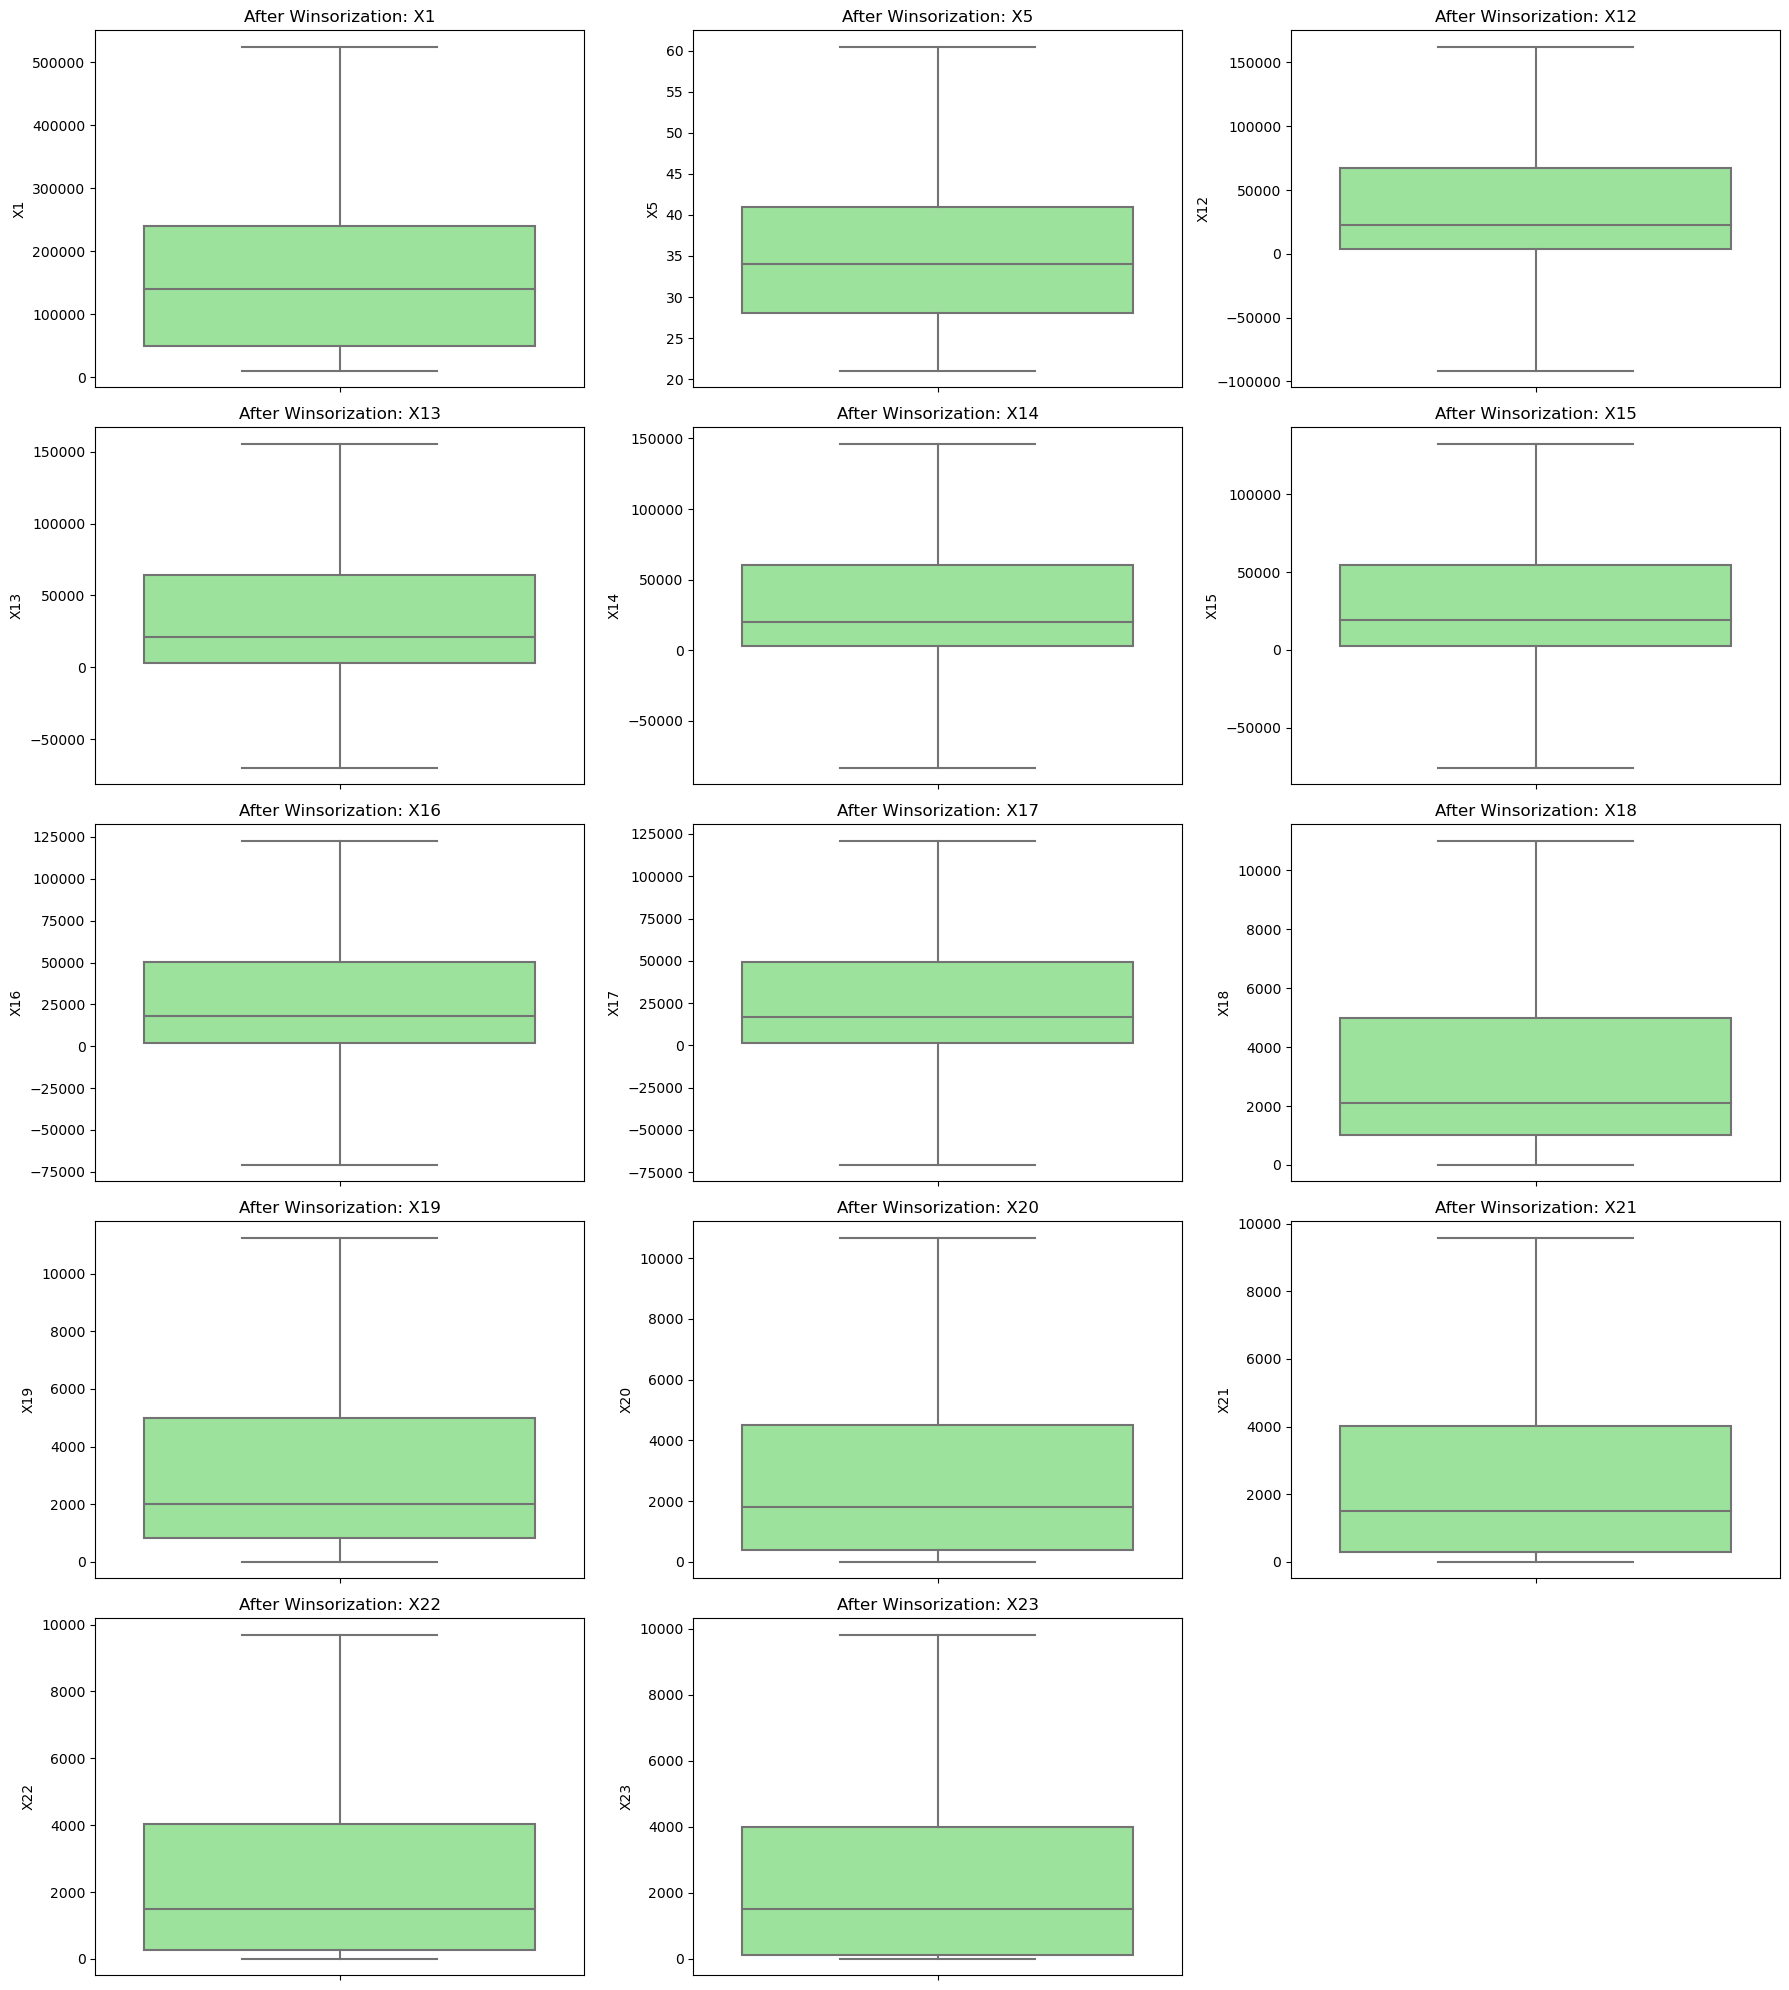

In [212]:
# boxplot after handling outliers
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
axes = axes.flatten()
for i, column in enumerate(data[num_features].columns):
    sns.boxplot(y=data[column], ax=axes[i], color='lightgreen')
    axes[i].set_title(f'After Winsorization: {column}')
# Hide unused subplots
for j in range(len(num_features), len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

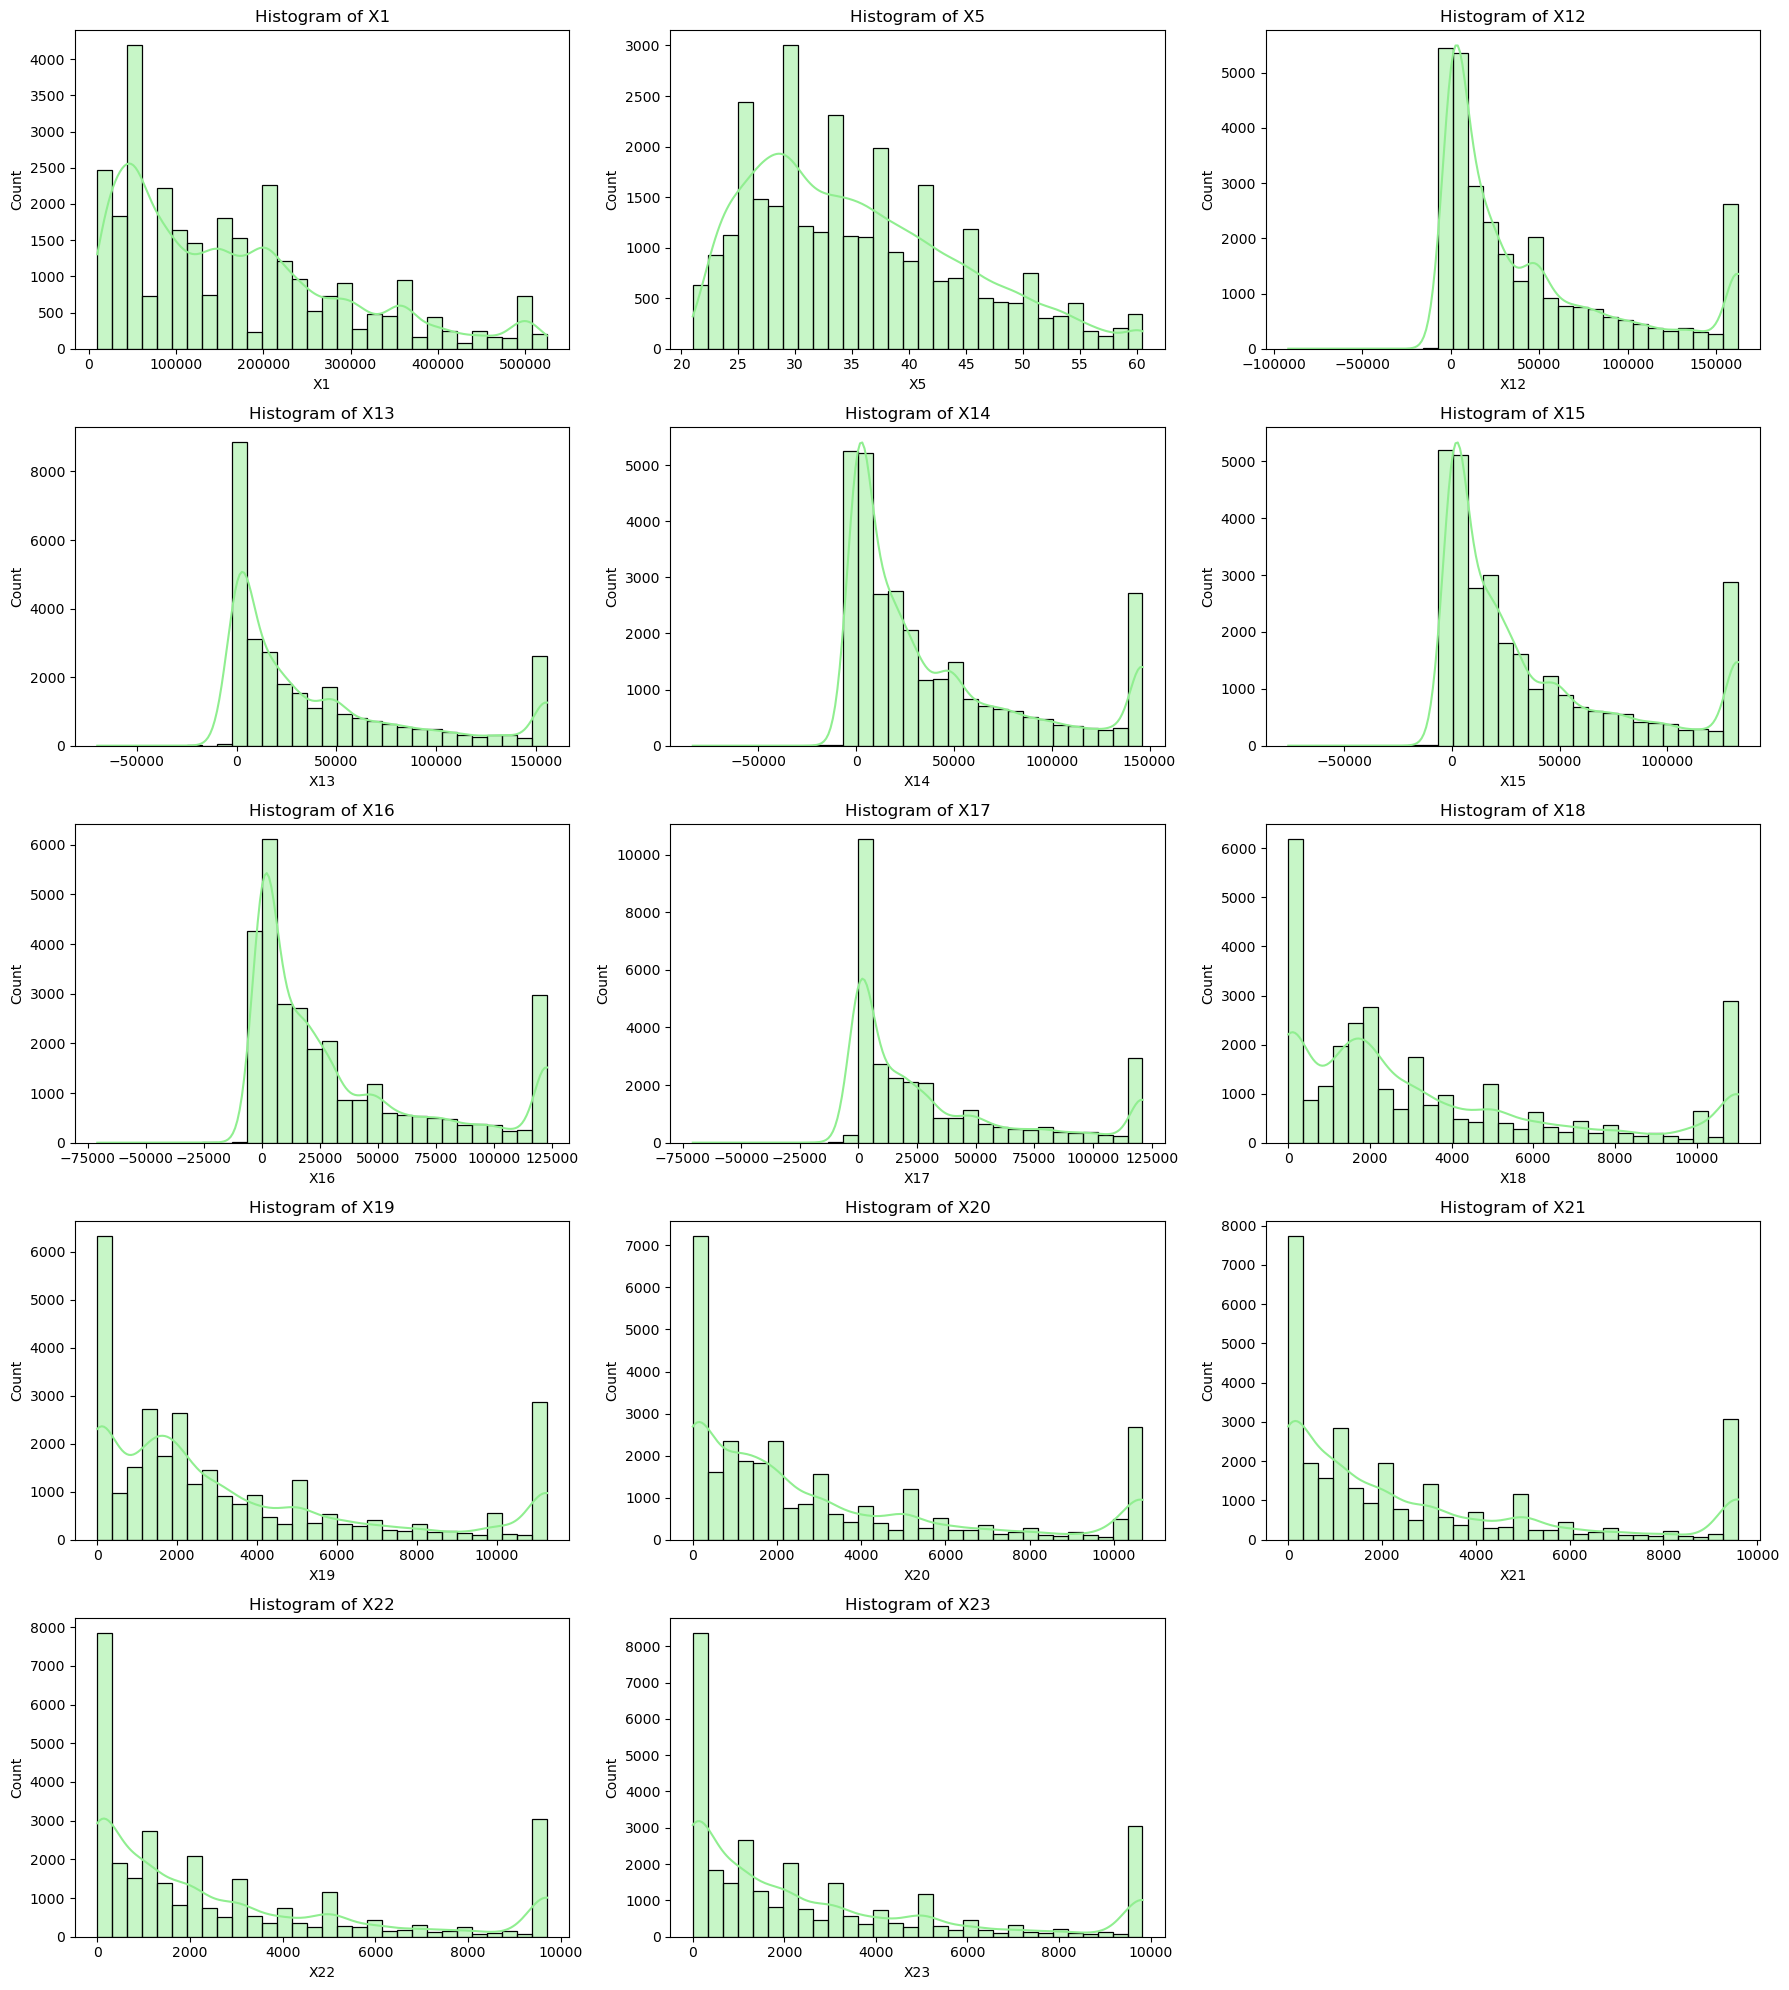

In [213]:
# visualize the distribution of the numerical features
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
axes = axes.flatten()
for i, column in enumerate(num_features):
    sns.histplot(data[column], bins=30, kde=True, ax=axes[i], color='lightgreen')
    axes[i].set_title(f'Histogram of {column}')

# Hide unused subplots
for j in range(len(num_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### **Feature Engineering**

In [214]:
# Feature Engineering to create meaningful features for credit card default prediction

# 1. Credit Utilization Features
data['credit_utilization_recent'] = data['X12'] / data['X1']  # Recent month utilization
data['credit_utilization_avg'] = (data['X12'] + data['X13'] + data['X14'] + data['X15'] + data['X16'] + data['X17']) / (6 * data['X1'])

# 2. Payment Behavior Features
# Overall payment ratio (total payments / total bills)
total_bills = data[['X12', 'X13', 'X14', 'X15', 'X16', 'X17']].sum(axis=1)
total_payments = data[['X18', 'X19', 'X20', 'X21', 'X22', 'X23']].sum(axis=1)
data['overall_payment_ratio'] = total_payments / (total_bills + 1)  # Add 1 to avoid division by zero

# Payment consistency (std of payment status)
payment_status_cols = ['X6', 'X7', 'X8', 'X9', 'X10', 'X11']
data['payment_consistency'] = data[payment_status_cols].std(axis=1)

# 3. Delay Analysis Features
# Count of months with delays (payment status > 0)
data['delay_frequency'] = (data[payment_status_cols] > 0).sum(axis=1)
data['severe_delay_count'] = (data[payment_status_cols] >= 2).sum(axis=1)
data['max_delay'] = data[payment_status_cols].max(axis=1)

# Delay trend (recent vs historical)
recent_delay = data[['X6', 'X7', 'X8']].mean(axis=1)
historical_delay = data[['X9', 'X10', 'X11']].mean(axis=1)
data['delay_trend'] = recent_delay - historical_delay

# 4. Bill and Payment Trends
bill_cols = ['X12', 'X13', 'X14', 'X15', 'X16', 'X17']
payment_cols = ['X18', 'X19', 'X20', 'X21', 'X22', 'X23']

# Bill trend (difference between recent and older bills)
data['bill_trend'] = data[['X12', 'X13', 'X14']].mean(axis=1) - data[['X15', 'X16', 'X17']].mean(axis=1)

# Bill volatility (standard deviation of bills)
data['bill_volatility'] = data[bill_cols].std(axis=1)

# 5. Demographic Risk Features
# Age risk categories
data['age_risk_young'] = (data['X5'] <= 30).astype(int)
data['age_risk_senior'] = (data['X5'] >= 60).astype(int)

# Education risk (higher education = lower risk, so invert)
data['education_risk'] = (data['X3'] >= 3).astype(int)

# Gender-marital interaction (single males might be higher risk)
data['single_male'] = ((data['X2'] == 1) & (data['X4'] == 2)).astype(int)

# 6. Interaction Features
# Credit utilization and age interaction
data['utilization_age_interaction'] = data['credit_utilization_recent'] * data['X5']

# High credit with young age (potential risk)
data['high_credit_young'] = ((data['X1'] > data['X1'].quantile(0.75)) & (data['X5'] <= 30)).astype(int)

print("Feature Engineering completed!")
print(f"Original features: 23")
print(f"New features added: {len(data.columns) - 24}")  # 24 includes original 23 + target Y
print(f"Total features: {len(data.columns) - 1}")  # Exclude target Y

# Display some of the new features
print("\nSample of engineered features:")
feature_cols = ['credit_utilization_recent', 'credit_utilization_avg', 'overall_payment_ratio', 
                'payment_consistency', 'delay_frequency', 'severe_delay_count', 'max_delay']
print(data[feature_cols].head())

Feature Engineering completed!
Original features: 23
New features added: 16
Total features: 39

Sample of engineered features:
   credit_utilization_recent  credit_utilization_avg  overall_payment_ratio  \
0                   0.195650                0.064200               0.089422   
1                   0.022350                0.023718               0.292774   
2                   0.324878                0.188246               0.108387   
3                   0.939800                0.771113               0.036259   
4                   0.172340                0.364463               0.307468   

   payment_consistency  delay_frequency  severe_delay_count  max_delay  
0             1.861899                2                   2          2  
1             1.224745                2                   2          2  
2             0.000000                0                   0          0  
3             0.000000                0                   0          0  
4             0.516398           

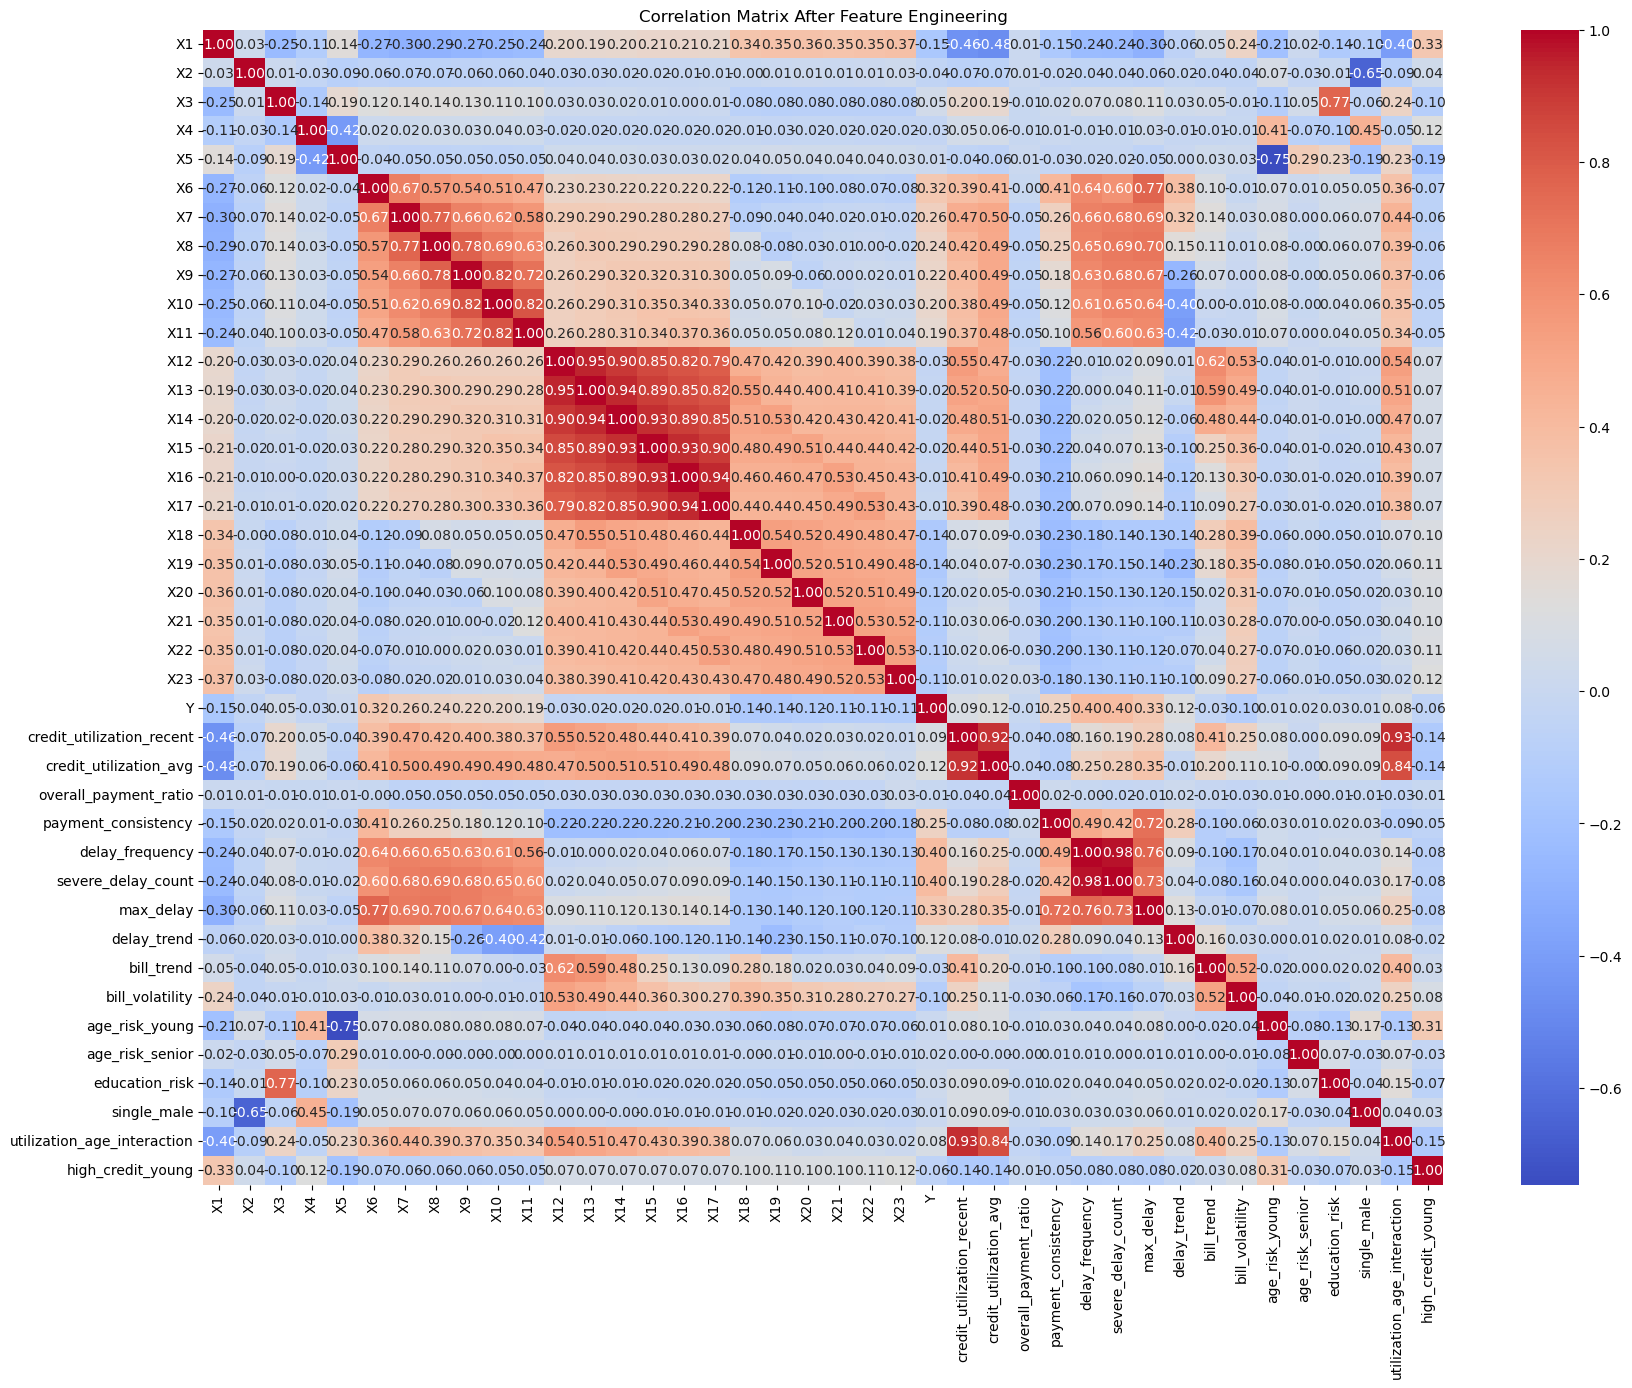

In [215]:
# correlation matrix after feature engineering
plt.figure(figsize=(20,15))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix After Feature Engineering')
plt.show()

### **Splitting Data**

In [216]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Y', axis=1),
    data['Y'],
    test_size=0.2,
    random_state=seed,
    stratify=data['Y']
)

### **Imbalance Data Handling**

In [218]:
adasyn = ADASYN(random_state=seed)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

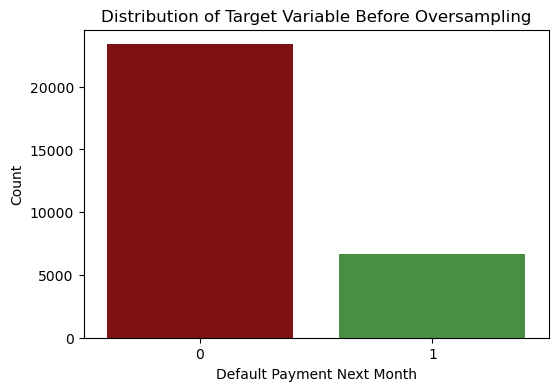

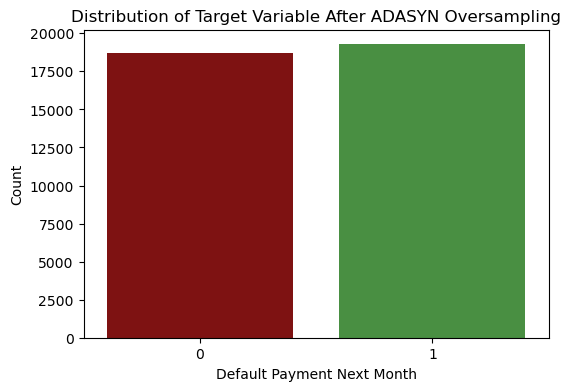

In [219]:
# data plot comparation before and after oversampling
# Before Oversampling
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x=data['Y'], palette=['#900000', '#3e9c35'], ax=ax)
ax.set_title('Distribution of Target Variable Before Oversampling')
ax.set_xlabel('Default Payment Next Month')
ax.set_ylabel('Count')
plt.show()

# After Oversampling
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x=y_train, palette=['#900000', '#3e9c35'], ax=ax)
ax.set_title('Distribution of Target Variable After ADASYN Oversampling')
ax.set_xlabel('Default Payment Next Month')
ax.set_ylabel('Count')
plt.show()

### **Scaling**

In [223]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Modelling**
### **Model Parameters**

In [224]:
patience = 20
batch_size = 64
epochs = 200
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=patience, 
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5', 
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

### **Model Architcture**

In [226]:
# Set seeds for reproducibility
tf.random.set_seed(seed)

model = keras.Sequential([
    # input layer
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # hidden layers
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    
    # output layer
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

In [246]:
# Model architecture visualization using both pydot and graphviz
# Method 1: Using keras.utils.plot_model with pydot
keras.utils.plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=150
)
print("Model architecture saved as 'model_architecture.png'")

# Method 2: Create a simple text-based visualization
print("\n" + "="*60)
print("NEURAL NETWORK ARCHITECTURE")
print("="*60)

model.summary()

# Method 3: Custom visualization using graphviz
dot = graphviz.Digraph(comment='Neural Network Architecture')
dot.attr(rankdir='TB')
dot.attr('node', shape='box', style='rounded,filled', fillcolor='lightblue')

# Add nodes for each layer
dot.node('input', f'Input Layer\n({X_train.shape[1]} features)')
dot.node('dense1', 'Dense Layer 1\n(256 neurons)\nReLU + BatchNorm + Dropout(0.3)')
dot.node('dense2', 'Dense Layer 2\n(512 neurons)\nReLU + BatchNorm + Dropout(0.3)')
dot.node('dense3', 'Dense Layer 3\n(256 neurons)\nReLU + BatchNorm + Dropout(0.3)')
dot.node('dense4', 'Dense Layer 4\n(128 neurons)\nReLU + BatchNorm + Dropout(0.3)')
dot.node('dense5', 'Dense Layer 5\n(64 neurons)\nReLU + Dropout(0.3)')
dot.node('output', 'Output Layer\n(1 neuron)\nSigmoid')

# Add edges
dot.edge('input', 'dense1')
dot.edge('dense1', 'dense2')
dot.edge('dense2', 'dense3')
dot.edge('dense3', 'dense4')
dot.edge('dense4', 'dense5')
dot.edge('dense5', 'output')

# Render the graph
dot.render('neural_network_architecture', format='png', cleanup=True)
print("Custom architecture visualization saved as 'neural_network_architecture.png'")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model architecture saved as 'model_architecture.png'

NEURAL NETWORK ARCHITECTURE
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 256)               10240     
                                                                 
 batch_normalization_28 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_31 (Dropout)        (None, 256)               0         
                                                                 
 dense_40 (Dense)            (None, 512)               131584    
                                                                 
 batch_normalization_

### **Model Training**

In [228]:
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_split=0.2,
                    verbose=1, 
                    callbacks=callbacks)

Epoch 1/200
470/475 [============================>.] - ETA: 0s - loss: 0.5883 - accuracy: 0.7164
Epoch 1: val_accuracy improved from -inf to 0.74832, saving model to best_model.h5
475/475 [==============================] - 6s 11ms/step - loss: 0.5875 - accuracy: 0.7168 - val_loss: 0.4825 - val_accuracy: 0.7483 - lr: 0.0010
Epoch 2/200
471/475 [============================>.] - ETA: 0s - loss: 0.5092 - accuracy: 0.7657
Epoch 2: val_accuracy improved from 0.74832 to 0.75135, saving model to best_model.h5
475/475 [==============================] - 5s 11ms/step - loss: 0.5085 - accuracy: 0.7662 - val_loss: 0.4595 - val_accuracy: 0.7513 - lr: 0.0010
Epoch 3/200
472/475 [============================>.] - ETA: 0s - loss: 0.4845 - accuracy: 0.7783
Epoch 3: val_accuracy improved from 0.75135 to 0.79942, saving model to best_model.h5
475/475 [==============================] - 5s 10ms/step - loss: 0.4849 - accuracy: 0.7781 - val_loss: 0.3790 - val_accuracy: 0.7994 - lr: 0.0010
Epoch 4/200
473/475

## **Evaluation**

In [229]:
# Make predictions
model.load_weights('best_model.h5')
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Additional metrics
print("Additional Metrics:")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

188/188 [==============================] - 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      4673
           1       0.60      0.38      0.46      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000

Additional Metrics:
Precision: 0.5993
Recall: 0.3798
F1-Score: 0.4649


188/188 [==============================] - 0s 2ms/step
[[4336  337]
 [ 823  504]]


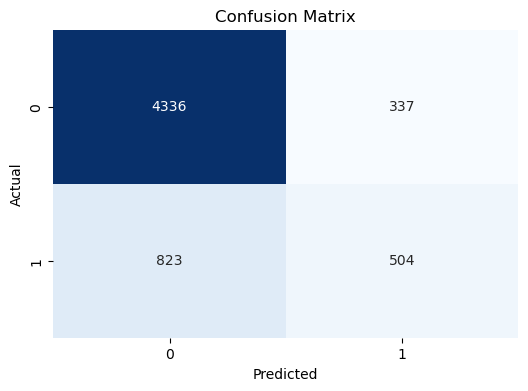

In [230]:
print(confusion_matrix(y_test, (model.predict(X_test) > 0.5).astype("int32")))

# confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

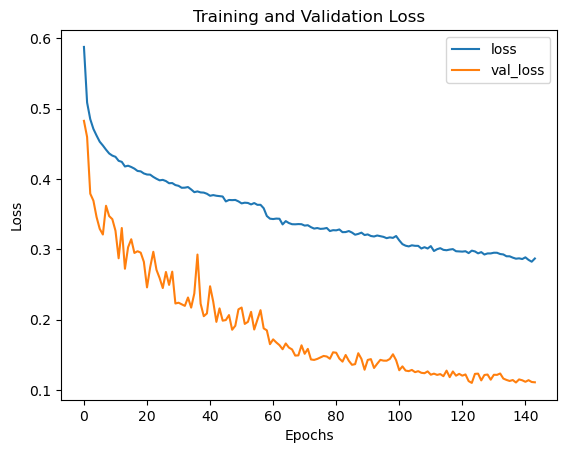

Minimum validation loss: 0.11021876335144043


In [231]:
# Get the history from the model fitting (from cell 50)
# Note: You need to re-run cell 50 and assign the result to history variable
# For now, let's create a simple plot from the model's training
try:
	# If history was saved from model.fit(), use it
	if 'history' in locals() and history is not None:
		history_df = pd.DataFrame(history.history)
		history_df.loc[:, ['loss', 'val_loss']].plot()
		plt.title('Training and Validation Loss')
		plt.xlabel('Epochs')
		plt.ylabel('Loss')
		plt.legend()
		plt.show()
		print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
	else:
		print("History not available. Please re-run the training cell (cell 50) and assign model.fit() result to 'history' variable.")
		print("Example: history = model.fit(...)")
except Exception as e:
	print(f"Error plotting history: {e}")
	print("Please ensure the training was completed and history was saved.")